ANALYSES SISMIQUE DEPUIS 1965

IMPORT DES LIBRAIRIES


In [1]:
#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install scipy
#!pip3 install seaborn
#!pip3 install sklearn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import DistanceMetric
from time import perf_counter 
import warnings
#!pip3 install folium
import datetime

warnings.simplefilter(action='ignore')



AFFICHAGE DU HEAD DU DATASET

In [2]:
hearthquake = pd.read_csv("./hearthquake.csv")
#Retrait colonnes vides
empty_columns = [col for col in hearthquake.columns
                     if hearthquake[col].isnull().any()]
hearthquake = hearthquake.drop(empty_columns, axis=1)
hearthquake.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,6.0,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,5.8,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,5.8,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


ICI ON VA CHARGER LES DATAS DES PLAQUES TECTONIQUES

In [3]:
tectonic_plates = pd.read_csv("./all.csv" )
tectonic_plates.head()

,plate,lat,lon
0,am,30.754,132.824
1,am,30.970,132.965
2,am,31.216,133.197
3,am,31.515,133.500
4,am,31.882,134.042


lE DATASET DES PLAQUES TECTONIQUES VA NOUS PERMETTRE DE GEOLOCALISER L'EMPLACEMENT DES SEISMES

En parcourant le dataset , dans la colonne date je me suis aperçu que 3 date n'était pas formaté comme les autres ainsi que la colone time.
Je vais donc les reformater. 

In [4]:
lengths_date = hearthquake["Date"].str.len()
lengths_date.value_counts()
dates_to_reformate = np.where([lengths_date == 24])[1]
#Je n'ai pas réussi à convertir automatiquement , j'ai donc fait le remplacement manuellement
hearthquake.loc[3378, "Date"] = "02/23/1975"
hearthquake.loc[3378, "Time"] = "02:58:41"
hearthquake.loc[7512, "Date"] = "04/28/1985"
hearthquake.loc[7512, "Time"] = "02:53:41"
hearthquake.loc[20650, "Date"] = "03/13/2011"
hearthquake.loc[20650, "Time"] = "02:23:34"
hearthquake['Date']= pd.to_datetime(hearthquake["Date"])
hearthquake.info()
#On peut voir grace à info que la colonne date est bien un datetime maintenant

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              23412 non-null  datetime64[ns]
 1   Time              23412 non-null  object        
 2   Latitude          23412 non-null  float64       
 3   Longitude         23412 non-null  float64       
 4   Type              23412 non-null  object        
 5   Depth             23412 non-null  float64       
 6   Magnitude         23412 non-null  float64       
 7   ID                23412 non-null  object        
 8   Source            23412 non-null  object        
 9   Location Source   23412 non-null  object        
 10  Magnitude Source  23412 non-null  object        
 11  Status            23412 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 2.1+ MB


Maintenant que nos données sont formatées correctement , alors on va voir lévolution des séismes avec le temps 

Text(0.5, 0, 'Date')

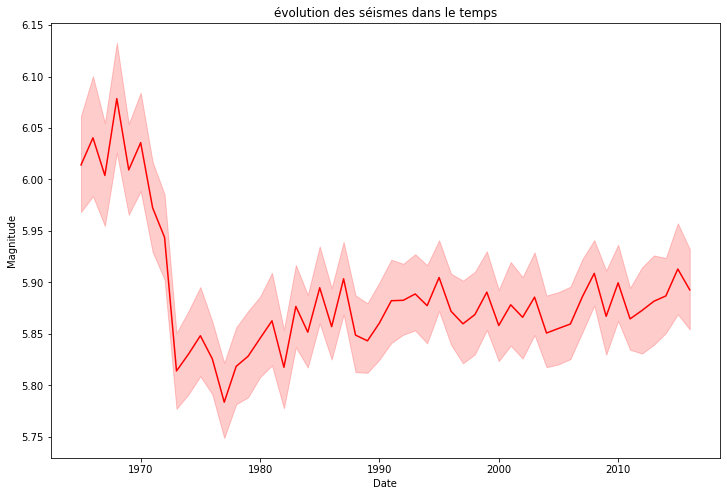

In [5]:
plt.figure(figsize=(12,8))
hearthquake_by_year = sns.lineplot(x=hearthquake['Date'].dt.year,y="Magnitude",data=hearthquake, color="#FF0000")
hearthquake_by_year.set_title("évolution des séismes dans le temps", color="#000000")
hearthquake_by_year.set_ylabel("Magnitude", color="#000000")
hearthquake_by_year.set_xlabel("Date", color="#000000")

Lors de mon parcours du data set , j'ai pu remarquer plusieurs types de séismes enregistrés, nous allons essayer de les visualiser

<AxesSubplot:xlabel='Type', ylabel='count'>

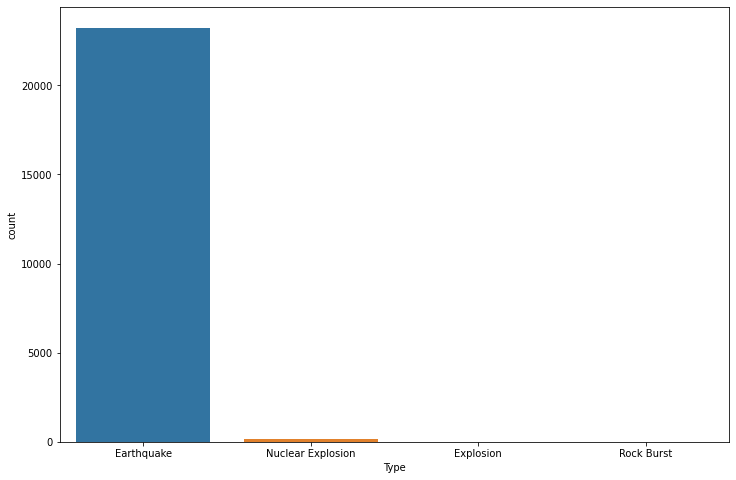

In [6]:
hearthquake_categorycal = hearthquake
#hearthquake_categorycal['Type'] = hearthquake['Type'].astype("category")
#hearthquake_categorycal['Type'] = hearthquake_categorycal['Type'].astype("category")
plt.figure(figsize=(12,8))

#categorical_columns = hearthquake.select_dtypes(['category']).columns
#hearthquake_categorycal['Type'] = hearthquake_categorycal['Type'].replace(to_replace=
                                        #['Earthquake', 'Nuclear Explosion', 'Explosion', 'Rock Burst'],
                                        #value=[1, 2, 3,4], inplace=True
                                       #)
hearthquake_categorycal.head()
#categorical_columns
#Index([u'col2', u'col3'], dtype='object')

sns.countplot(x="Type", data=hearthquake_categorycal)

([<matplotlib.patches.Wedge at 0x7fe572d338d0>,
 [Text(-0.02656642457863987, -1.0996791464264055, 'Earthquake'),
  Text(0.027304159591849703, 1.0996610763635235, 'Nuclear explosion'),
  Text(0.0013283062636256868, 1.0999991980008303, 'Explosion'),
  Text(0.0005902765133448506, 1.0999998416243695, 'Rock Burst')],
 [Text(-0.014490777042894473, -0.5998249889598575, '99%'),
  Text(0.014893177959190745, 0.5998151325619218, '1%'),
  Text(0.0007245306892503746, 0.5999995625459075, '0%'),
  Text(0.0003219690072790094, 0.5999999136132924, '0%')])

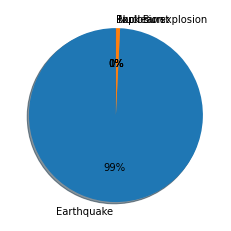

In [7]:
datas = []
nbquake = hearthquake[hearthquake["Type"] == 'Earthquake']
nbquakenuclear = hearthquake[hearthquake["Type"] == 'Nuclear Explosion']
nbquakerock = hearthquake[hearthquake["Type"] == 'Rock Burst']
nbquakeexplosion = hearthquake[hearthquake["Type"] == 'Explosion']

#nbquake['ID'].count()
#nbquakenuclear['ID'].count()
#nbquakerock['ID'].count()
#nbquakeexplosion['ID'].count()
datas = [nbquake['ID'].count(),nbquakenuclear['ID'].count(),nbquakerock['ID'].count(),nbquakeexplosion['ID'].count()]
label = ['Earthquake', 'Nuclear explosion', 'Explosion', 'Rock Burst']
plt.pie(datas, labels=label, autopct='%0.f%%', shadow=True, startangle=90)

Grace à ce chart on voit quon peut catégoriser les seismes en deux catégorie, les tremblements de terre naturels et ceux provoquer par une explosion, je vais donc regouper les trois catégories d'explosions ensemble

([<matplotlib.patches.Wedge at 0x7fe572cb4210>,
 [Text(-0.02656642457863987, -1.0996791464264055, 'Earthquake'),
  Text(0.026566350576576865, 1.0996791482141701, 'Explosion')],
 [Text(-0.014490777042894473, -0.5998249889598575, '99%'),
  Text(0.014490736678132833, 0.5998249899350018, '1%')])

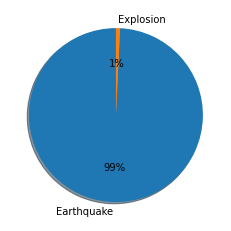

In [8]:
datas = [nbquake['ID'].count(),nbquakenuclear['ID'].count() + nbquakerock['ID'].count() + nbquakeexplosion['ID'].count()]
label = ['Earthquake', 'Explosion']
plt.pie(datas, labels=label, autopct='%0.f%%', shadow=True, startangle=90)

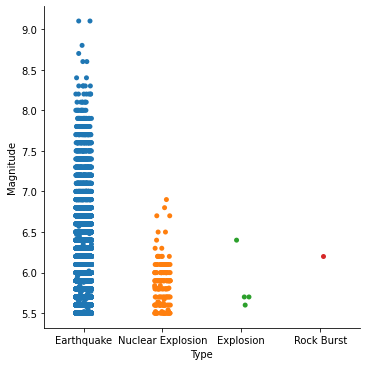

In [9]:
sns.catplot(x="Type", y='Magnitude',
                data=hearthquake_categorycal)

Ce graphique nous permet de voir qua la grande majorité des séismes sont d'ordre naturel et sont également les plus violents, lors du prochain graphique, nous allons essayer de déterminer la profondeur moyenne des séisme et leur magnitude moyenne 

Text(0.5, 0, 'Magnitude')

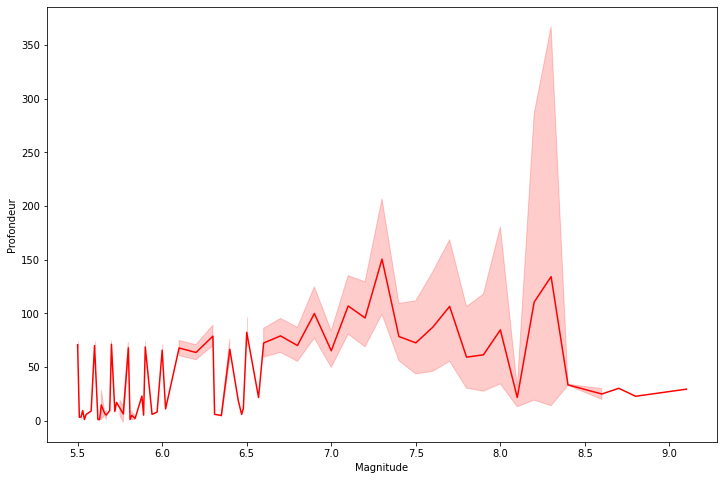

In [10]:
plt.figure(figsize=(12,8))
hearthquake_by_mag = sns.lineplot(x=hearthquake['Magnitude'],y="Depth",data=hearthquake, color="#FF0000")
#hearthquake_by_mag.set_title("évolution des séismes dans le temps", color="#000000")
hearthquake_by_mag.set_ylabel("Profondeur", color="#000000")
hearthquake_by_mag.set_xlabel("Magnitude", color="#000000")

In [11]:
hearthquake.mean()

Latitude      1.679033
Longitude    39.639961
Depth        70.767911
Magnitude     5.882531
dtype: float64

À l'aide de cette map, on peut voir que la grande majorité des séismes sont situé sur les délimitations des plaques tectoniques.

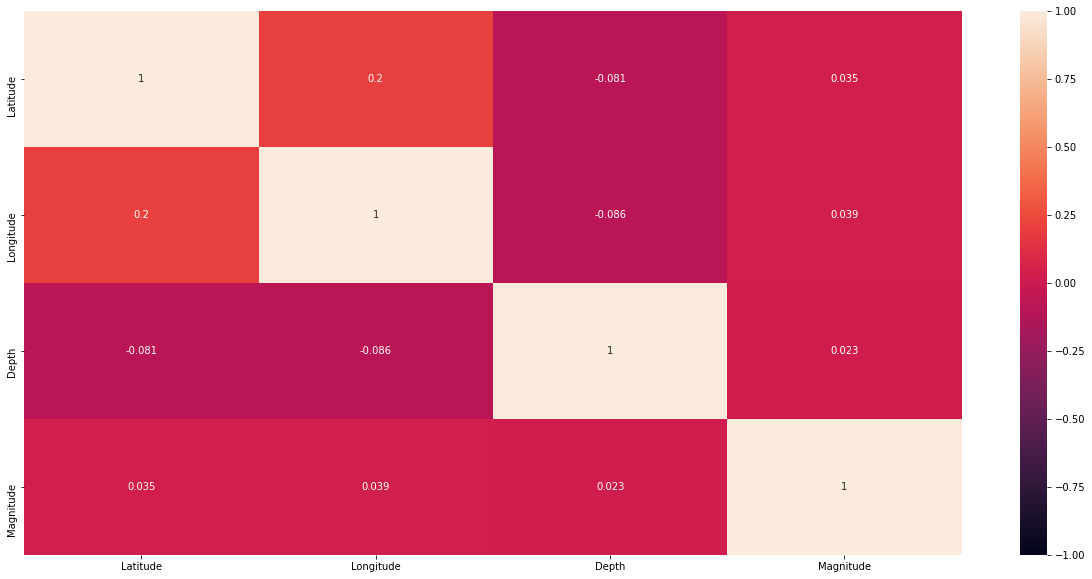

In [12]:
numeric_columns = [column for column in hearthquake.columns if hearthquake.dtypes[column] != 'object']
corr = hearthquake[numeric_columns].corr()
plt.figure(figsize=(21, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, vmax=1.0)
plt.show()


Le premier algorythme de train va etre dédier à tenter de prédire la magnitude des seismes et peut etre la longitude et latitude

In [13]:
#hearthquake.info()
X = hearthquake[['Latitude','Longitude', 'Depth']]

X.shape

Y = hearthquake['Magnitude']
Y.shape
from sklearn.model_selection import train_test_split
#X, Y = train_test_split(new_frame, test_size=300, train_size=699, random_state=42, shuffle=True, stratify=None)
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.4, random_state=42)

In [14]:
from sklearn import linear_model

regr = linear_model.LinearRegression().fit(X_train, y_train)
print('Coefficients beta_j : \n', regr.coef_)
print('Coefficients INTERCEPT beta_0 : \n', regr.intercept_)


Coefficients beta_j : 
 [0.00047133 0.00014306 0.00010256]
Coefficients INTERCEPT beta_0 : 
 5.86803692879355


In [15]:

#afficher les coefficients 
regr.coef_

array([0.00047133, 0.00014306, 0.00010256])

[Text(0, 0, 'Latitude'), Text(1, 0, 'Longitude'), Text(2, 0, 'Depth')]

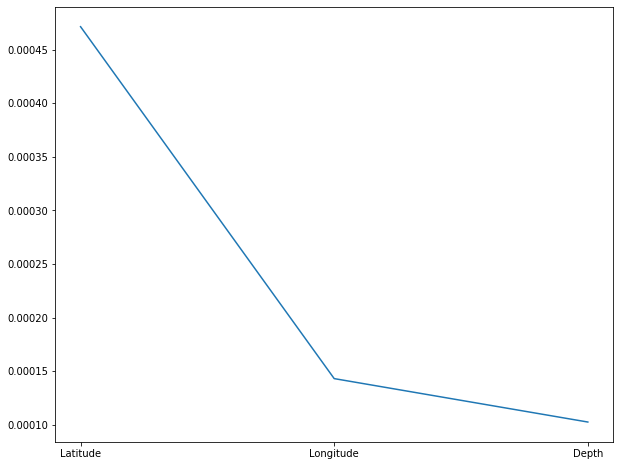

In [16]:

#ploter les coefficients avec les bon noms
#que remarquez vous ? 
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
plt.xticks([0,1, 2,])
g = sns.lineplot(data= regr.coef_)
names = ['Latitude','Longitude', 'Depth']
g.set_xticklabels(names)

In [17]:

# Fit Model
linear_model.LinearRegression().fit(X_train, y_train)
# Predict
y_pred = regr.predict(X_test)
y_pred



array([5.90215452, 5.88549827, 5.89068392, ..., 5.86532361, 5.83859876,
       5.87029544])

Le second algorythme de train va etre dédier à tenter de prédire le type de séisme (naturel , ou explosion).

In [18]:
regr.score(X,Y)

0.003001562761637544